# Random Forests model

#### Importing the data

In [1]:
# @hidden_cell
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_4ce2b21ebf484e98948d2c0b81b8b84f(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'admin_c24f02ccead8f3d4baea656ecbccd8e6e38d474d','domain': {'id': '8d5c5723b93e4bdf8c5be53de58a2395'},
            'password': 'D!~GY/p7Z]b##1oV'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

data_train = pd.read_csv(get_object_storage_file_with_credentials_4ce2b21ebf484e98948d2c0b81b8b84f('seminaire_data', 'Transformed_features.csv'), index_col=False)
data_train.head()

,Unnamed: 0,installer_f,installer_fnr,extraction_type_f,extraction_type_fnr,source_f,source_fnr,waterpoint_type_group_f,waterpoint_type_group_fnr,management_f,...,scheme_management_fnr,lga_f,lga_fnr,basin_f,basin_fnr,amount_tsh,permit,age_pump,public_meeting,target
0,0,0.606383,0.074468,0.599253,0.100859,0.622290,0.074966,0.576491,0.083986,0.504234,...,0.063436,0.774823,0.019504,0.653687,0.049164,6000,0,36,1,0
1,1,0.846154,NaN,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.599540,...,0.028721,0.592179,0.037709,0.497658,0.096507,0,1,47,-1,0
2,2,0.654412,0.132353,0.599253,0.100859,0.385671,0.036585,0.576491,0.083986,0.504234,...,0.063436,0.581169,0.016234,0.600895,0.053356,25,1,46,1,0
3,3,0.536036,0.040541,0.551217,0.047649,0.489571,0.044334,0.576491,0.083986,0.504234,...,0.063436,0.265823,NaN,0.371689,0.072557,0,1,23,1,2
4,4,0.555556,0.044444,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.598341,...,NaN,0.530480,0.058366,0.497658,0.096507,0,1,-1,1,0


### Preparing the data (normalization, splitting training and test ...)

In [2]:
data_train = data_train.iloc[:, 1:]

In [3]:
data_train.head()

,installer_f,installer_fnr,extraction_type_f,extraction_type_fnr,source_f,source_fnr,waterpoint_type_group_f,waterpoint_type_group_fnr,management_f,management_fnr,...,scheme_management_fnr,lga_f,lga_fnr,basin_f,basin_fnr,amount_tsh,permit,age_pump,public_meeting,target
0,0.606383,0.074468,0.599253,0.100859,0.622290,0.074966,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.774823,0.019504,0.653687,0.049164,6000,0,36,1,0
1,0.846154,NaN,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.599540,0.099002,...,0.028721,0.592179,0.037709,0.497658,0.096507,0,1,47,-1,0
2,0.654412,0.132353,0.599253,0.100859,0.385671,0.036585,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.581169,0.016234,0.600895,0.053356,25,1,46,1,0
3,0.536036,0.040541,0.551217,0.047649,0.489571,0.044334,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.265823,NaN,0.371689,0.072557,0,1,23,1,2
4,0.555556,0.044444,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.598341,0.065166,...,NaN,0.530480,0.058366,0.497658,0.096507,0,1,-1,1,0


In [4]:
# Transforming the data into numpy arrays

Y = (data_train.target).tolist()
y = np.asarray(Y)

In [5]:
# Dropping the y column and the time column

data_train.drop('target', axis=1, inplace=True)

In [6]:
# Transforming the data frame into an array

X = data_train.as_matrix()
X.shape

# First we fill the Nan values with the mean (first approach)

X = np.where(np.isnan(X), np.ma.array(X, mask = np.isnan(X)).mean(axis=0), X)

In [7]:
# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

#Splitting the data into training and test sets (80% (includes the cross validation set) - 20%)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:((4 * X.shape[0]) / 5)], indices[((4 * X.shape[0]) / 5):]
X_train, y_train, X_test, y_test = X[train_idx,:], y[train_idx], X[test_idx,:], y[test_idx]

### Random forests model

The random forests model is a bagging of decision trees. The dataset is resampled to build a decision tree, and our prediction is based on the mean prediction of the various decision trees. This model reduces variance by taking into account different viewpoints on the data (the viewpoints are dictated by the partial resampling used to fit each tree in the forest).

To best exploit this model, we need to see which parameters do best : number of trees to consider fitting, the maximum number of variables to consider for each tree, and the depth of the tree. Since we have 28 variables, and knowing that common practice in choosing the depth of the tree as the square root of the number of variablest, we choose to go a little bit beyond that to have a better shot at achieving a high accuracy.

In [25]:
# Using the classifier to find the best tuning parameters

from sklearn.ensemble import RandomForestClassifier as rfc

classifiers = []
precisions = []

# The range of the parameters to explore
estimators = range(10,41,3)
variables = range(3,10)
depths = range(3,10)

for estimator in estimators:
    print(estimator)
    for var in variables:
        for depth in depths:
            classifier = rfc(n_estimators = estimator, max_features = var, max_depth = depth)
            classifier.fit( X_train, y_train)
            pred = classifier.predict(X_test)
            precisions.append(np.mean((pred==y_test)))
            classifiers.append(classifier)

Classif = classifiers[np.argmax(precisions)]

10
13
16
19
22
25
28
31
34
37
40


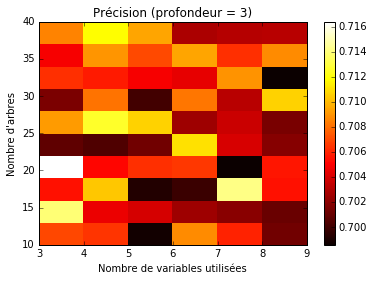

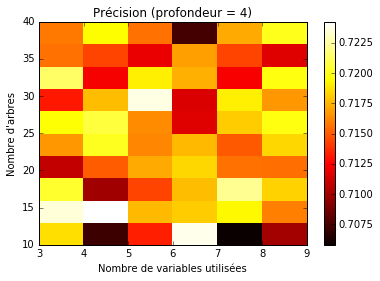

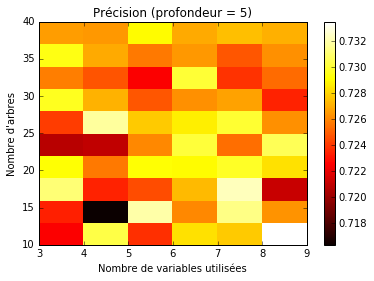

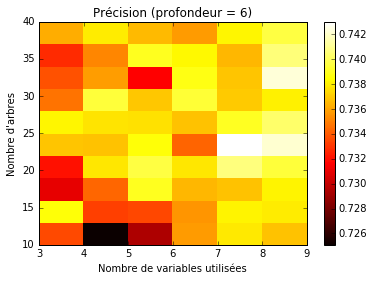

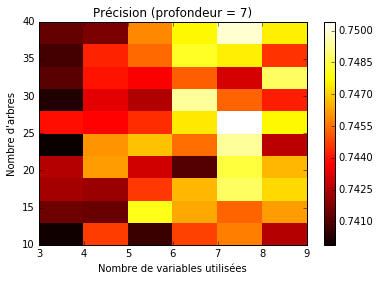

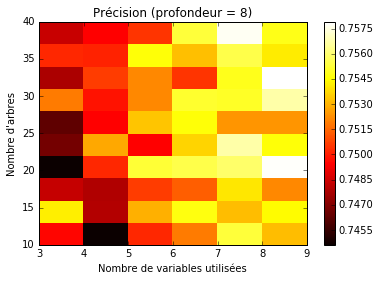

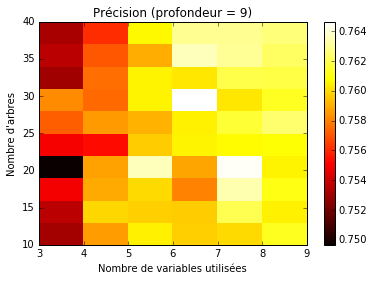

In [27]:
# Plotting the precisions on test set for the different values of the depth
import matplotlib.pyplot as plt
import pylab as pl
% matplotlib inline

precisions = np.array(precisions).reshape((11,7,7))

for depth in depths:
    plt.figure()
    plt.pcolor(np.array(variables) ,np.array(estimators), precisions[:,:,depth-3], cmap='hot')
    plt.title(u'Précision (profondeur = '+str(depth) + ')')
    plt.xlabel(u'Nombre de variables utilisées')
    plt.ylabel(u"Nombre d'arbres")
    plt.colorbar()
    plt.show()
    